# Intercomparison

**Author:** Hannah Kerner, Ivan Zvonkov

**Last updated:** November 30, 2023

**Description:** Runs intercomparison for Rwanda 2019

## 1. Setup

In [1]:
#earthengine authenticate

In [2]:
import ee
import geemap
import sys
import pandas as pd
import geopandas as gpd

ee.Initialize()

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

## 2. Read in evaluation set

In [3]:
country = "Rwanda"
country_code = TEST_CODE[country]
dataset_path = "../" + TEST_COUNTRIES[country]

In [4]:
df = pd.read_csv(dataset_path)[["lat", "lon", "class_probability", "subset"]]
df = df[(df["class_probability"] != 0.5)].copy()
# use only test data because validation points used for harvest-dev map
df = df[df["subset"] == "testing"].copy()
df[CLASS_COL] = (df["class_probability"] > 0.5).astype(int)
df[COUNTRY_COL] = country

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

## 3. Run intercomparison

In [5]:
TARGETS = {k:v for k,v in TARGETS.items()}

In [6]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

[Rwanda] sampling copernicus...
[Rwanda] sampling worldcover-v100...
[Rwanda] sampling worldcover-v200...
[Rwanda] sampling worldcereal-v100...
[Rwanda] sampling glad...
[Rwanda] sampling asap...
[Rwanda] sampling dynamicworld...
[Rwanda] sampling gfsad-gcep...
[Rwanda] sampling gfsad-lgrip...
[Rwanda] sampling digital-earth-africa...
[Rwanda] sampling esa-cci-africa...
[Rwanda] sampling globcover-v23...
[Rwanda] sampling globcover-v22...
[Rwanda] sampling esri-lulc...
[Rwanda] sampling nabil-etal-2021...
[Rwanda] sampling harvest-dev...


In [7]:
comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap])
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

# Add ensemble
ensemble_maps = ["glad", "worldcover-v200", "esri-lulc"] # Should be odd number
print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf[ensemble_maps].mode(axis='columns')
comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

Ensemble maps: ['glad', 'worldcover-v200', 'esri-lulc']


,country,crop_f1,std_crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,noncrop_recall_pa,std_noncrop_pa,crop_precision_ua,std_crop_ua,noncrop_precision_ua,std_noncrop_ua,crop_support,noncrop_support,tn,fp,fn,tp
dataset,,,,,,,,,,,,,,,,,,,
copernicus,Rwanda,0.66,0.13,0.67,0.03,0.70,0.04,0.65,0.03,0.63,0.05,0.71,0.05,92,107,70,37,28,64
worldcover-v100,Rwanda,0.66,0.12,0.74,0.03,0.55,0.04,0.90,0.03,0.82,0.05,0.70,0.04,92,107,96,11,41,51
worldcover-v200,Rwanda,0.65,0.12,0.73,0.03,0.53,0.03,0.91,0.03,0.83,0.05,0.69,0.04,92,107,97,10,43,49
worldcereal-v100,Rwanda,0.39,0.10,0.63,0.03,0.25,0.02,0.96,0.02,0.85,0.07,0.60,0.04,92,107,103,4,69,23
glad,Rwanda,0.58,0.14,0.67,0.03,0.50,0.04,0.81,0.03,0.70,0.06,0.65,0.04,92,107,87,20,46,46
asap,Rwanda,0.67,0.12,0.65,0.03,0.77,0.04,0.55,0.03,0.60,0.05,0.74,0.05,92,107,59,48,21,71
dynamicworld,Rwanda,0.29,0.09,0.60,0.03,0.17,0.02,0.97,0.01,0.84,0.09,0.58,0.04,92,107,104,3,76,16
gfsad-gcep,Rwanda,0.65,0.13,0.65,0.03,0.70,0.04,0.61,0.03,0.60,0.05,0.70,0.05,92,107,65,42,28,64
gfsad-lgrip,Rwanda,0.63,0.13,0.63,0.03,0.68,0.04,0.58,0.03,0.58,0.05,0.68,0.05,92,107,62,45,29,63


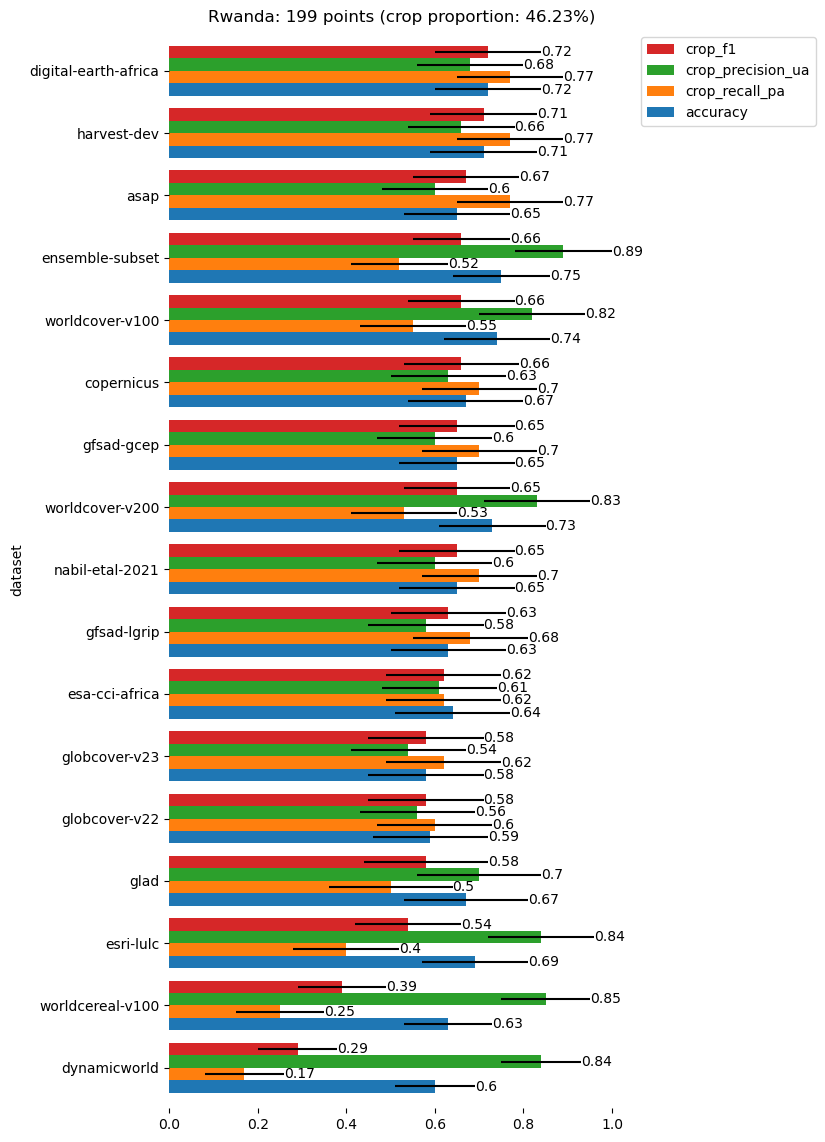

In [8]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"], 
    xerr="std_crop_f1",
    kind="barh", 
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Visualize best available map

In [9]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
best_dataset = results["crop_f1"].idxmax()
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")

To view and export map copy and paste the text below the dashed line into GEE
----------------------------------------------------------------------------------------------------

var palettes = require('users/gena/packages:palettes');
var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}
var aoi = ee.FeatureCollection("FAO/GAUL/2015/level0")
    .filter(ee.Filter.eq('ADM0_NAME', 'Rwanda'));
Map.centerObject(aoi, 7);

var digital_earth_africa = ee.ImageCollection("projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/filtered").filterBounds(aoi).mosaic().clip(aoi);
digital_earth_africa = digital_earth_africa.eq(1).rename('crop')
Map.addLayer(digital_earth_africa, classVis, 'Cropland from digital-earth-africa');
Export.image.toCloudStorage({
    image: digital_earth_africa,
    description: "Rwanda_digital_earth_africa",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: 'Rwanda_digital_earth_africa',
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e1